# Analysis of DNA binding mutants 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystan
import glob 
import sys
sys.path.insert(0, '../../')
import mut.bayes
import mut.viz
import mut.stats
import mut.thermo
colors = mut.viz.pub_style()
%matplotlib inline

In [17]:
# Load all of the 2018 flow data.
flow_files = glob.glob('../processing/2018*DNA*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)
flow_data = flow_data[(flow_data['fold_change'] >= -0.2) & (flow_data['fold_change'] <= 1.3)]

# Load the microscopy data
mic_files = glob.glob('../processing/2018*microscopy*/output/*fold_change.csv')
dfs = [pd.read_csv(f) for f in mic_files]
mic_data = pd.concat(dfs, axis=0)

In [18]:
# Isolate the leakiness data
leakiness = flow_data[(flow_data['IPTGuM'] ==0) & (flow_data['mutant'] != 'Q21M') &
                     (flow_data['mutant'] != 'auto') 
                     & (flow_data['mutant'] != 'delta') & (flow_data['mutant'] != np.nan) &
                     (flow_data['mutant'] != 'Q294K') & (flow_data['mutant'] != 'Q294V') &
                     (flow_data['mutant'] != 'F164T')].copy()
leakiness.drop('Unnamed: 0', axis=1, inplace=True)
leakiness.rename(columns={'mean_FITC_H':'mean_intensity'}, inplace=True)
leakiness.loc[:, 'method'] = 'flow'
mic_data.loc[:, 'method'] = 'microscopy'
merged = pd.concat([leakiness, mic_data], ignore_index=True)
merged = merged[(merged['mutant'] != 'none')]

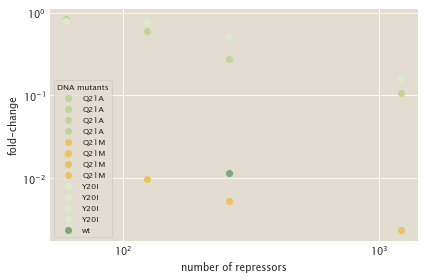

In [19]:
# Set up the figure canvas
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('number of repressors')
ax.set_ylabel('fold-change')
ax.set_xscale('log')
ax.set_yscale('log')

color_dict = {i:j for i, j in zip(merged['mutant'].unique(), list(colors.values()))}
grouped = merged.groupby(['mutant'])
i = 0
for g, d in grouped:
    _grouped = d.groupby('repressors')
    for _g, _d in _grouped:
        _d = _d.mean()
        ax.plot(_d['repressors'], _d['fold_change'], 'o', label=g, color=color_dict[g])
    i += 1     
    
_ = ax.legend(title='DNA mutants', fontsize=8)
plt.setp(_.get_title(), fontsize=8)
plt.tight_layout()

In [10]:
colors

{'blue': '#738FC1',
 'green': '#7AA974',
 'light_blue': '#A9BFE3',
 'light_green': '#BFD598',
 'light_purple': '#D4C2D9',
 'light_red': '#E8B19D',
 'light_yellow': '#F3DAA9',
 'pale_blue': '#C9D7EE',
 'pale_green': '#DCECCB',
 'pale_red': '#F1D4C9',
 'pale_yellow': '#FFEDCE',
 'purple': '#AB85AC',
 'red': '#D56C55',
 'yellow': '#EAC264'}

In [78]:
# Plot the data points. 
p1 = bokeh.plotting.figure(x_axis_label='repressor copy number',
                          y_axis_label='fold-change',
                          x_axis_type='log', y_axis_type='log',
                          plot_width=600, plot_height=400)

grouped = merged.groupby(['mutant'])
colors = bokeh.palettes.Accent8
i = 0
for g, d in grouped:
    _grouped = d.groupby('repressors')
    for _g, _d in _grouped:
        _d = _d.mean()
        p1.circle(_d['repressors'], _d['fold_change'], legend=g,
                     color=colors[i])
    i += 1
bokeh.io.show(p1)


In [83]:
# Include IDs for heirarchical model.
merged.loc[:, 'id'] = 1
merged.loc[merged['mutant'] == 'Q21A', 'id'] = 2
merged.loc[merged['mutant'] == 'Q21M', 'id'] = 3
merged.loc[merged['mutant'] == 'wt', 'id'] = 4

In [84]:
merged.head()

,IPTGuM,date,fold_change,mean_YFP,mean_intensity,method,mutant,operator,repressors,run_number,strain,username,id
0,0.0,20180213,-0.015005,NaN,4785.645314,flow,wt,O2,260.0,NaN,R260,gchure,4
1,0.0,20180322,0.055042,NaN,7558.367130,flow,wt,O2,260.0,NaN,R260,gchure,4
2,0.0,20180322,0.761336,NaN,12694.551352,flow,Q21A,O2,60.0,NaN,R60,gchure,2
3,0.0,20180322,0.279661,NaN,9191.802448,flow,Q21A,O2,260.0,NaN,R260,gchure,2
4,0.0,20180322,0.632680,NaN,11758.961989,flow,Q21A,O2,124.0,NaN,R124,gchure,2


In [85]:
def assemble_StanModelCode(model_file, function_file):
    """Returns a string of the stan model code from a model and function file"""
    lines = []
    files = [function_file, model_file]
    for f in files:
        with open(f, 'r') as file:
            out = file.read().splitlines()
            for line in out:
                lines.append(line) 
    model_code = """\n"""
    for line in lines:
        model_code += line + '\n'
    return model_code

In [86]:
model_code = assemble_StanModelCode('../stan/heirarchical_epR_fit.stan', '../stan/functions.stan')
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31d86c808853debbc6ac3a765ef665db NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpj4x5ap69/stanfit4anon_model_31d86c808853debbc6ac3a765ef665db_9141132330676789960.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpj4x5ap69/stanfit4anon_model_31d86c808853debbc6ac3a765ef665db_9141132330676789960.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [87]:
merged = merged[(merged['fold_change'] >= -0.2) & (merged['fold_change'] <= 1.3)]
# Assemble the data dictionary. 
ka = 139
ka_sigma = 30
ki = 0.53
ki_sigma = 0.04
data_dict = {'J':4, 'N':len(merged), 'trial':merged['id'].values,
            'R':merged['repressors'].values, 'n_ns':4.6E6, 'ka':ka, 'ki':ki,
            'ep_AI':4.5, 'n_sites':2, 'c':np.zeros(len(merged)), 'fc':merged['fold_change'].values}

# Sample the distribution.
samples = sm.sampling(data=data_dict, iter=5000, chains=4)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [40]:
def chains_to_dataframe(fit):
    data = fit.extract()
    keys = list(data.keys())
    varnames = [k for k in keys if 'lp__' not in k]
    samples = {}
    for i, key in enumerate(varnames):
        # Get the shape.
        dim = np.shape(data[key])
        if len(dim) == 2:
            for j in range(dim[-1]):
                samples['{}.{}'.format(key, j+1)] = data[key][:, j]
    
        else:
            samples[key] = data[key]
            
    # compute the log_post. 
    new_keys = samples.keys()
    logp = []
    for j in range(dim[0]):
        logp.append(fit.log_prob([samples[k][j] for k in fit.unconstrained_param_names()]))
        
    samples['logp'] = logp
    return pd.DataFrame(samples)
    

In [88]:
df = chains_to_dataframe(samples)

df.rename(columns={'ep_R.1':'epR_Y20I', 'ep_R.2':'epR_Q21A', 'ep_R.3':'epR_Q21M', 'ep_R.4':'epR_wt'},
         inplace=True)

In [121]:
df.to_csv('epR_fit_DNA_02_chains.csv')

In [89]:
stats = mut.stats.compute_statistics(df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [122]:
stats.to_csv('epR_fit_DNA_O2_stats.csv', index=False)

In [93]:
# Plot the fits. 
rep_range = np.logspace(0, 4, 500)
muts = merged['mutant'].unique()
ep_R = [stats[stats['parameter']=='epR_{}'.format(m)]['mode'].values[0] for m in muts]
ep_R_low = [stats[stats['parameter']=='epR_{}'.format(m)]['hpd_min'].values[0] for m in muts]
ep_R_high = [stats[stats['parameter']=='epR_{}'.format(m)]['hpd_max'].values[0] for m in muts]
meshed_R, meshed_ep = np.meshgrid(rep_range, ep_R)
meshed_R_low, meshed_ep_high = np.meshgrid(rep_range, ep_R_high)
meshed_R_high, meshed_ep_low = np.meshgrid(rep_range, ep_R_low)
arch = mut.thermo.SimpleRepression(R=meshed_R, ep_r=meshed_ep, ep_ai=4.5, ka=139, ki=0.53,
                                  n_sites=int(2), n_ns=4.6E6, effector_conc=0)
arch_high = mut.thermo.SimpleRepression(R=meshed_R_high, ep_r=meshed_ep_high, ep_ai=4.5, ka=139, ki=0.53,
                                  n_sites=int(2), n_ns=4.6E6, effector_conc=0)
arch_low = mut.thermo.SimpleRepression(R=meshed_R_low, ep_r=meshed_ep_low, ep_ai=4.5, ka=139, ki=0.53,
                                  n_sites=int(2), n_ns=4.6E6, effector_conc=0)
fc = arch.fold_change()
fc_high = arch_high.fold_change()
fc_low = arch_low.fold_change()
# Set up the figure. 
color_cycle = ['tomato', 'dodgerblue', 'slategrey', 'coral']
color_dict = {i: j for i, j in zip(muts, color_cycle)}
p = bokeh.plotting.figure(plot_width=600, plot_height=400, x_axis_type='log',
                         y_axis_type='log', x_axis_label='repressor copy number',
                         y_axis_label='fold-change')
for i in range(4):
    p.line(rep_range, fc[i, :], color=color_cycle[i], line_width=2, 
           legend='{} = {:0.1f} +{:0.1f} -{:0.1f} k_BT'.format(muts[i], ep_R[i], 
                    np.abs(ep_R[i]) - np.abs(ep_R_high[i]), 
                    np.abs(ep_R_low[i]) - np.abs(ep_R[i])), alpha=0.5)
    band_x = np.append(rep_range, rep_range[::-1])
    band_y = np.append(fc_low[i, ], fc_high[i, ::-1])
    p.patch(band_x, band_y, color=color_cycle[i], alpha=0.3)
    
    
# Plot the data points. 
grouped = merged.groupby(['mutant', 'repressors'])
for g, d in grouped:
    p.circle(g[1], d['fold_change'].mean(), color=color_dict[g[0]])
p.legend.location = 'bottom_left'    
bokeh.io.show(p)

###  Plotting the titration curves.

In [95]:
c_range = np.logspace(-2, 4, 500)
reps = flow_data['repressors'].unique()
reps = np.sort(reps[reps > 0])

# 
c, ep, R = np.meshgrid(c_range, ep_R, reps) 
c_low, ep_low, R_low = np.meshgrid(c_range, ep_R_low, reps) 
c_high, ep_high, R_high = np.meshgrid(c_range, ep_R_high, reps) 
fc = mut.thermo.SimpleRepression(R=R, ep_r=ep, effector_conc=c, ep_ai=4.5,
                                ka=ka, ki=ki, n_sites=2, n_ns=4.6E6).fold_change()
fc_low = mut.thermo.SimpleRepression(R=R_low, ep_r=ep_low, effector_conc=c_low, ep_ai=4.5,
                                ka=ka, ki=ki, n_sites=2, n_ns=4.6E6).fold_change()   
fc_high = mut.thermo.SimpleRepression(R=R_high, ep_r=ep_high, effector_conc=c_high, ep_ai=4.5,
                                ka=ka, ki=ki, n_sites=2, n_ns=4.6E6).fold_change()

fcs = [fc, fc_low, fc_high]

rep_color = bokeh.palettes.Category10_5
rep_dict = {i:j for i, j in zip(reps, rep_color)}
canvas = []
for i, m in enumerate(muts):
    _p = bokeh.plotting.figure(plot_width=350, plot_height=250, x_axis_type='log',
                               x_axis_label='IPTG [µM]', y_axis_label='fold-change',
                              title=m)
    for j, R in enumerate(reps):
        if i == 0:
            legend = str(R)
        else:
            legend = False
        _p.line(c_range, fc[i, :, j], color=rep_dict[R], line_width=1, alpha=0.5,
               legend=legend)
        band_x = np.append(c_range, c_range[::-1])
        band_y = np.append(fc_low[i,:, j], fc_high[i, ::-1, j])
        _p.patch(band_x, band_y, color=rep_dict[R], alpha=0.3)
   
        
        # Plot the data.
        mut_flow = flow_data[(flow_data['mutant'] == m) & (flow_data['repressors'] == R)]
        grouped = mut_flow.groupby('IPTGuM')
        for g, d in grouped:
            mean_fc = d['fold_change'].mean()
            sem_fc = d['fold_change'].std() / np.sqrt(len(d))
            
            _p.circle(g, mean_fc, color=rep_dict[R], size=2)
            _p.line((g, g), (mean_fc - sem_fc, mean_fc + sem_fc), color=rep_dict[R])
            
        
    if i==0:
        _p.legend.location = 'bottom_right'
    canvas.append(_p)
    
layout = bokeh.layouts.gridplot([[canvas[0], canvas[1]], [canvas[2], canvas[3]]])
bokeh.io.show(layout)

In [96]:
import imp
imp.reload(mut.thermo)

<module 'mut.thermo' from '../../mut/thermo.py'>

##  Computing the properties.

In [97]:
# assemble the data ignoring Q21M
dna_muts = flow_data[(flow_data['mutant'] == 'Q21M') | (flow_data['mutant']=='Y20I') | 
                    (flow_data['mutant'] == 'Q21A') | (flow_data['mutant'] == 'wt')]
dna_muts = dna_muts[(dna_muts['mutant'] != 'Q21M') | (dna_muts['IPTGuM'] > 0)]
mic_data['IPTGuM'] = 0

merged_global = pd.concat([mic_data[mic_data['mutant']=='Q21M'], dna_muts])

# Restrict to only the useful information. 
merged_global = merged_global[['IPTGuM', 'mutant', 'repressors', 'fold_change']]

idx = {'Q21M':1, 'Q21A':2, 'Y20I':3, 'wt':4}
for k in idx.keys():
    merged_global.loc[merged_global['mutant']==k, 'id'] = int(idx[k])
    
merged_global = merged_global[(merged_global['fold_change'] >= -0.2) & (merged_global['fold_change'] <= 1.3)]

In [119]:
merged_global.to_csv('merged_dna_O2_data.csv', index=False)

In [136]:
# Assemble the data frame for fitting each individual strain.
unique_R = merged_global.repressors.unique()
unique_mut = merged_global.mutant.unique()
n_combinations = 3 * len(unique_R) + 1
label_key = {}
label = 1
for i, R in enumerate(unique_R):
    for j, m in enumerate(unique_mut):
        if m == 'wt':
            R = 260
        merged_global.loc[(merged_global['mutant'] == m) & (merged_global['repressors']== R), 
                             'fit_idx'] = label
        label_key[label] = (R, m)
        if m != 'wt':
            label += 1 

In [99]:
# Compile the stan model.
model_code = assemble_StanModelCode('../stan/heirarchical_single_strain_fit.stan',
                                   '../stan/functions.stan')
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecef4474642aa89221d27f86523ebb8d NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpfjqm7kiv/stanfit4anon_model_ecef4474642aa89221d27f86523ebb8d_8493649227853169447.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpfjqm7kiv/stanfit4anon_model_ecef4474642aa89221d27f86523ebb8d_8493649227853169447.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [137]:
# Assemble the data dictionary.
data_dict = {'J': int(n_combinations), 'N': len(merged_global), 'trial':merged_global['fit_idx'].astype(int),
            'R':merged_global['repressors'], 'n_ns':4.6E6, 'ep_ai':4.5, 'n_sites':int(2), 
             'c': merged_global['IPTGuM'], 'fc':merged_global['fold_change']}

# Sample!
samples = sm.sampling(data=data_dict, iter=3000, chains=1)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [138]:
# Convert to dataframe and rename columns. 
strain_fit_df = chains_to_dataframe(samples)
new_cols = {'{}.{}'.format(v.split('.')[0], i+1):'R_{}_{}_{}'.format(int(label_key[k][0]), v.split('.')[0], label_key[k][1]) for i, k in enumerate(label_key.keys()) for v in samples.constrained_param_names()}
strain_fit_df.rename(columns = new_cols, inplace=True)

In [139]:
label_key

{1: (1220.0, 'Q21M'),
 2: (260, 'Q21A'),
 3: (260, 'Y20I'),
 4: (124.0, 'Q21M'),
 5: (260, 'Q21A'),
 6: (260, 'Y20I'),
 7: (260.0, 'Q21M'),
 8: (260, 'Q21A'),
 9: (260, 'Y20I'),
 10: (60.0, 'Q21M'),
 11: (260, 'Q21A'),
 12: (260, 'Y20I')}

In [140]:
strain_fit_df.to_csv('global_fit_single_strain_DNA_O2_chains.csv', index=False)

In [141]:
strain_fit_stats = mut.stats.compute_statistics(strain_fit_df)
strain_fit_stats
sttrain_fit_stats.to_csv('global_fit_single_strain_DNA_O2_stats.csv', index=False)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


IndexError: index 1540 is out of bounds for axis 0 with size 1500

In [142]:
strain_fit_stats

,parameter,mode,hpd_min,hpd_max
0,R_1220_ep_R_Q21M,-12.956821,-18.709264,-12.318101
1,R_60_ep_R_Q21M,-14.826016,-17.922539,-14.077535
2,R_60_ep_R_Q21A,-9.653534,-9.857467,-9.375960
3,R_60_ep_R_Y20I,-9.692250,-10.053112,-9.672324
4,ep_R.13,54.588239,-202.312052,189.938402
5,R_1220_ep_R_Q21A,-10.172479,-10.589855,-10.133139
6,R_1220_ep_R_Y20I,-9.960761,-10.285191,-9.425476
7,R_124_ep_R_Q21M,-14.462924,-19.901846,-13.272231
8,R_124_ep_R_Q21A,-10.086821,-10.166335,-9.903650
9,R_124_ep_R_Y20I,-9.265287,-9.715188,-9.256437


In [103]:
strain_fit_df

,R_1220_ep_R_Q21M,R_260_ep_R_wt,R_260_ep_R_Q21A,R_260_ep_R_Y20I,R_60_ep_R_Q21M,R_60_ep_R_wt,R_60_ep_R_Q21A,R_60_ep_R_Y20I,R_1220_ep_R_wt,R_1220_ep_R_Q21A,...,R_60_sigma_Q21A,R_60_sigma_Y20I,R_1220_sigma_wt,R_1220_sigma_Q21A,R_1220_sigma_Y20I,R_124_sigma_Q21M,R_124_sigma_wt,R_124_sigma_Q21A,R_124_sigma_Y20I,R_260_sigma_Q21M
0,-14.790468,-13.439901,-10.660750,-9.918446,-15.745165,-56.870997,-9.687659,-9.924677,-103.480059,-10.248562,...,0.056279,0.046658,0.572422,0.035519,0.098790,0.077108,5.980332,0.049204,0.075198,0.080995
1,-15.572703,-16.221990,-10.643372,-9.965193,-14.968509,17.127149,-9.674238,-9.914991,-7.626250,-10.471945,...,0.061016,0.039309,1.880949,0.042415,0.109708,0.091784,6.943556,0.059991,0.075313,0.067082
2,-15.749762,-15.227618,-10.634499,-9.872963,-14.839170,-136.818963,-9.657340,-9.764675,-49.030865,-10.120909,...,0.055541,0.047036,18.158288,0.039093,0.112595,0.073213,4.878590,0.058770,0.072807,0.079586
3,-12.582360,-14.188136,-10.650728,-9.837189,-15.552671,-58.648481,-9.615142,-9.952200,-31.584167,-10.439234,...,0.056594,0.044202,2.722136,0.038204,0.111697,0.080670,6.833696,0.045831,0.068520,0.091275
4,-14.181999,-13.615555,-10.625842,-10.100608,-15.503726,77.915801,-9.711907,-9.915101,-172.765308,-10.383219,...,0.063313,0.042763,8.692341,0.041495,0.090238,0.082175,2.326601,0.053940,0.077636,0.095654
5,-17.773203,-13.891061,-10.707337,-9.911682,-14.828928,183.788473,-9.530261,-10.068785,0.446521,-10.461706,...,0.052427,0.038619,2.746623,0.041998,0.112701,0.077556,6.699693,0.055934,0.076217,0.077842
6,-14.303212,-13.990258,-10.633844,-9.896513,-14.670916,34.424486,-9.528677,-9.788390,28.008407,-10.293485,...,0.055844,0.054242,8.935938,0.039249,0.108993,0.069819,6.133527,0.058633,0.080273,0.089447
7,-14.152876,-13.649704,-10.638343,-10.336440,-14.433624,123.942752,-9.576835,-9.894529,126.840063,-10.282147,...,0.059152,0.047368,0.431752,0.034531,0.111567,0.072836,2.720323,0.051796,0.081505,0.084951
8,-16.447794,-13.292111,-10.704540,-9.466130,-14.601906,-169.778587,-9.692457,-9.921248,-135.360016,-10.344969,...,0.055382,0.045269,11.592902,0.035335,0.107741,0.073632,4.505367,0.046776,0.105282,0.086330
9,-13.066438,-13.963455,-10.611815,-9.703336,-15.125615,-15.916147,-9.688102,-9.908954,-43.920673,-10.387881,...,0.056346,0.043037,10.440894,0.042030,0.113838,0.074992,5.085470,0.042887,0.081448,0.073841


In [107]:
strain_fit_stats

,parameter,mode,hpd_min,hpd_max
0,R_1220_ep_R_Q21M,-14.156104,-19.929340,-12.392898
1,R_260_ep_R_wt,-13.622783,-15.998275,-12.848967
2,R_260_ep_R_Q21A,-10.933229,-10.981399,-10.546328
3,R_260_ep_R_Y20I,-10.126455,-10.169295,-9.679332
4,R_60_ep_R_Q21M,-15.723558,-18.125001,-13.954519
5,R_60_ep_R_wt,-25.927393,-196.458133,202.534880
6,R_60_ep_R_Q21A,-9.602285,-9.845424,-9.367095
7,R_60_ep_R_Y20I,-9.907031,-10.049091,-9.663014
8,R_1220_ep_R_wt,-121.009092,-191.223734,187.598098
9,R_1220_ep_R_Q21A,-10.499746,-10.593305,-10.164155


In [105]:
import imp
imp.reload(mut.thermo)

<module 'mut.thermo' from '../../mut/thermo.py'>

In [129]:
# Compute  and plot the properties. 
ka = 139
ki = 0.53

p1 = bokeh.plotting.figure(plot_width=340, plot_height=300, x_axis_type='log',
                          y_axis_type='log', x_axis_label='repressors per cell',
                          y_axis_label='leakiness')

p2 = bokeh.plotting.figure(plot_width=340, plot_height=300, x_axis_type='log',
                           x_axis_label='repressors per cell',
                          y_axis_label='saturation')

p3 = bokeh.plotting.figure(plot_width=340, plot_height=300, x_axis_type='log',
                          x_axis_label='repressors per cell',
                          y_axis_label='dynamic range')

p4 = bokeh.plotting.figure(plot_width=340, plot_height=300, x_axis_type='log',
                          x_axis_label='repressors per cell', y_axis_type='log',
                          y_axis_label='ec50')

p5 = bokeh.plotting.figure(plot_width=340, plot_height=300, x_axis_type='log',
                          x_axis_label='repressors per cell',
                          y_axis_label='effective hill coefficient')
canvas = [p1, p2, p3, p4, p5]
rep_range = np.logspace(0, 4, 500)
color_palette = bokeh.palettes.viridis(4)


for i, m in enumerate(ep_R):
    
    # mesh the bounds and instantiate the architecture.
    low = ep_R_low[i]
    high = ep_R_high[i]
    vals = np.array([m, low, high])
    r, ep = np.meshgrid(rep_range, vals)
    
    arch = mut.thermo.SimpleRepression(R=r, ep_r=ep, ka=ka, ki=ki, ep_ai=4.5,
                                      effector_conc=0, n_sites=2) 
    properties = arch.compute_properties()
    for j, p in enumerate(properties.keys()):
        canvas[j].line(rep_range, properties[p][0, :], color=color_palette[i])
        bandx = np.append(rep_range, rep_range[::-1])
        bandy = np.append(properties[p][1, :], properties[p][2, ::-1])
        canvas[j].patch(bandx, bandy, color=color_palette[i], alpha=0.4)
    

# Plot the data.
for i, m in enumerate(muts):
    _d = merged_global[merged_global['mutant']==m]
    
    # Plot the leakiness.
    grouped = _d.groupby(['repressors', 'IPTGuM'])
    leak, sat = {}, {}
    for g, d in grouped:
        mean_fc = d['fold_change'].mean()
        sem_fc = d['fold_change'].std() / np.sqrt(len(d))
        if g[1] == 0.0:     
            p1.circle(g[0], mean_fc, color=color_palette[i], legend=m)
            p1.line((g[0], g[0]), (mean_fc - sem_fc, mean_fc + sem_fc),
                        color=color_palette[i], line_width=2)
            leak[g[0]] = (mean_fc, sem_fc)
        if g[1] == 5000.0:
            p2.circle(g[0], mean_fc, color=color_palette[i])
            p2.line((g[0], g[0]), (mean_fc - sem_fc, mean_fc + sem_fc),
                        color=color_palette[i], line_width=2)           
            sat[g[0]] = (mean_fc, sem_fc)
    for j, r in enumerate(leak.keys()):
        p3.circle(r, sat[r][0] - leak[r][0], color=color_palette[i])
        p3.line((r, r), ((sat[r][0] - sat[r][1]) - (leak[r][0] + leak[r][1]),
                         (sat[r][0] + sat[r][1]) - (leak[r][0] - leak[r][1])),
               color=color_palette[i], line_width=2)
        
# Plot the EC50 and Effective hill.
for i, R in enumerate(unique_R):
    for j, M in enumerate(muts):
        
        if M == 'wt':
            R = 260 
        # Isolate the statistics for each.
        ep = strain_fit_stats.loc[strain_fit_stats['parameter']=='R_{}_ep_R_{}'.format(int(R), M)]['mode']
        fit_ka = strain_fit_stats.loc[strain_fit_stats['parameter']=='R_{}_ka_{}'.format(int(R), M)]['mode']
        fit_ki = strain_fit_stats.loc[strain_fit_stats['parameter']=='R_{}_ki_{}'.format(int(R), M)]['mode']
       
        # Instantiate the architecture and compute the properties
        arch = mut.thermo.SimpleRepression(R=R, ep_r=ep.values[0], ka=fit_ka.values[0], ki=fit_ki.values[0], effector_conc=0, 
                                          n_ns=4.6E6, ep_ai=4.5, n_sites=2)
        ec50 = arch.ec50()
        hill = arch.effective_hill()
        
        # Compute the credible region for each.
        traces = strain_fit_df[['R_{}_ep_R_{}'.format(int(R), M),
                                'R_{}_ka_{}'.format(int(R), M),
                                'R_{}_ki_{}'.format(int(R), M)]]
        labels = traces.keys()
        arch = mut.thermo.SimpleRepression(R=R, ep_r=traces[labels[0]], ka=traces[labels[1]], ki=traces[labels[2]], effector_conc=0, 
                                          n_ns=4.6E6, ep_ai=4.5, n_sites=2)
        ec50_bounds = mut.stats.compute_hpd(arch.ec50(), mass_frac=0.95)
        hill_bounds = mut.stats.compute_hpd(arch.effective_hill(), mass_frac=0.95)
        p4.square(R, ec50, color=color_palette[j])
        p4.line((R, R), (ec50_bounds[0], ec50_bounds[1]), line_width=2, color=color_palette[j])
        p5.line((R, R), (hill_bounds[0], hill_bounds[1]), line_width=2, color=color_palette[j])
        p5.square(R, hill, color=color_palette[j])
        
p1.legend.location = 'bottom_left' 
layout = bokeh.layouts.gridplot([[p1, p2], [p3, p4]])
bokeh.io.show(p5)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [133]:
strain_fit_stats

,parameter,mode,hpd_min,hpd_max
0,R_1220_ep_R_Q21M,-12.956821,-18.709264,-12.318101
1,R_60_ep_R_Q21M,-14.826016,-17.922539,-14.077535
2,R_60_ep_R_Q21A,-9.653534,-9.857467,-9.375960
3,R_60_ep_R_Y20I,-9.692250,-10.053112,-9.672324
4,ep_R.13,54.588239,-202.312052,189.938402
5,R_1220_ep_R_Q21A,-10.172479,-10.589855,-10.133139
6,R_1220_ep_R_Y20I,-9.960761,-10.285191,-9.425476
7,R_124_ep_R_Q21M,-14.462924,-19.901846,-13.272231
8,R_124_ep_R_Q21A,-10.086821,-10.166335,-9.903650
9,R_124_ep_R_Y20I,-9.265287,-9.715188,-9.256437


In [143]:
# Assemble the stan model. 
model_code = assemble_StanModelCode('../stan/heirarchical_global_fit.stan', '../stan/functions.stan')
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3198df66611bae5461852af739aa7b26 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpcb3gs845/stanfit4anon_model_3198df66611bae5461852af739aa7b26_8544884028042185076.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpcb3gs845/stanfit4anon_model_3198df66611bae5461852af739aa7b26_8544884028042185076.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [144]:
# Assemble the data dictionary.
data_dict = {'J': 4, 'N': len(merged_global), 'R':merged_global['repressors'],
            'c':merged_global['IPTGuM'], 'trial':merged_global['id'].astype(int), 'n_ns':4.6E6,
            'ep_ai':4.5, 'n_sites':2, 'fc':merged_global['fold_change']}
global_fit = sm.sampling(data=data_dict, iter=4000, chains=2)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [145]:
merged_global

,IPTGuM,mutant,repressors,fold_change,id,fit_idx
0,0.0,Q21M,1220.0,0.002361,1.0,1.0
1,0.0,Q21M,124.0,0.008905,1.0,4.0
2,0.0,Q21M,260.0,0.004392,1.0,7.0
3,0.0,Q21M,60.0,0.019252,1.0,10.0
0,0.0,Q21M,1220.0,0.003210,1.0,1.0
1,0.0,Q21M,124.0,0.011943,1.0,4.0
2,0.0,Q21M,260.0,0.006621,1.0,7.0
3,0.0,Q21M,60.0,0.021316,1.0,10.0
1,0.0,wt,260.0,-0.015005,4.0,11.0
7,0.1,Q21M,1220.0,-0.045721,1.0,1.0


In [173]:
id_key = {1:'Q21M', 2:'Q21A', 3:'Y20I', 4:'wt'}
global_df = chains_to_dataframe(global_fit)
new_ep_cols = {'ep_R.{}'.format(i+1):'epR_{}'.format(id_key[i+1]) for i in range(4)}
new_ka_cols = {'ka.{}'.format(i+1): 'ka_{}'.format(id_key[i+1]) for i in range(4)}
new_ki_cols = {'ki.{}'.format(i+1): 'ki_{}'.format(id_key[i+1]) for i in range(4)}

global_df.rename(columns=new_ep_cols, inplace=True)
global_df.rename(columns=new_ka_cols, inplace=True)
global_df.rename(columns=new_ki_cols, inplace=True)
global_fit_stats = mut.stats.compute_statistics(global_df)


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [175]:
global_fit_stats.to_csv('../../data/global_fit_DNA_O2_stats.csv')